In [20]:
import geopandas as gpd
import numpy as np
import shapely
import rasterio
from shapely.geometry import Point, MultiPoint
from matplotlib import pyplot as plt

from rasterio.plot import show

import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# testing for branches

In [6]:
# # Define file paths
# sipit_centerline_path = r'D:/AMH Philippines, Inc/PP23.307 Rockwell and Roll - General/06 NP23.000 WORK FILES/Richmond/My Documents/Python/amh_pyqgis/flow_extraction/Sipit_RAS/GIS/merged_cl.shp'
# baranca_ref_line_shp_path = r"D:\AMH Philippines, Inc\PP23.307 Rockwell and Roll - General\06 NP23.000 WORK FILES\Richmond\My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\GIS\Reference Lines\baranca.shp"

# terrain_path = r"D:\AMH Philippines, Inc\PP23.307 Rockwell and Roll - General\06 NP23.000 WORK FILES\Richmond\My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\Terrain\Terrain.Client Topo.tif"

# Define File Paths for my PC
sipit_centerline_path = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\GIS\merged_cl.shp"
baranca_ref_line_shp_path = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\GIS\Reference Lines\ref_lines.shp"
terrain_path = r"C:\Users\richmond\AMH Philippines, Inc\PP23.307 Rockwell and Roll - My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\Terrain\Terrain.Client Topo.tif"

C2 - Sta 0+000: 2 intersection points


AttributeError: 'LineString' object has no attribute 'plot'

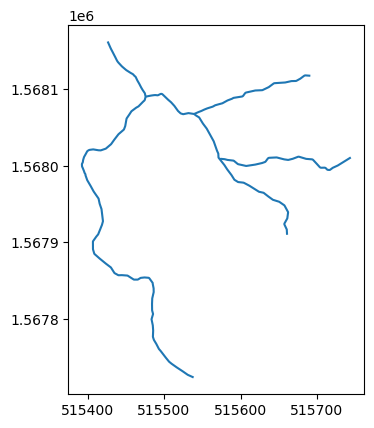

In [ ]:
fig, ax = plt.subplots()
gdf_sipit = gpd.read_file(sipit_centerline_path).to_crs('EPSG:3123')
gdf_sipit.plot(ax=ax)

gdf_baranca_ref_line = gpd.read_file(baranca_ref_line_shp_path).to_crs('EPSG:3123')
# gdf_baranca_ref_line.plot(ax=ax)

# with rasterio.open(terrain_path) as src:
#     # transform rasterio plot
#     extent = [src.bounds[0], src.bounds[1], src.bounds[2], src.bounds[3]]
#     ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')

#     i=0
#     for i in range(0,len(gdf_baranca_ref_line)):
#         ref_line = gdf_baranca_ref_line.iloc[i].geometry
#         point = shapely.intersection(ref_line, gdf_sipit.geometry)
#         valid_points = point[point.notna() & ~point.is_empty & (point.geom_type == 'Point')]
#         valid_points.plot(ax=ax, color='black')

#         x_coor = valid_points.x
#         y_coor = valid_points.y
#         coord_list = [(x_coor, y_coor)]
#         sampled_raster = np.array([arr[0] for arr in src.sample(coord_list)])
#         print(sampled_raster)

i == 0
for i in range(len(gdf_baranca_ref_line)):
    row      = gdf_baranca_ref_line.iloc[i]
    ref_line = row.geometry
    name     = row['Name']

    # 1) intersect each Sipit feature against this ref_line…
    hits = gdf_sipit.geometry.intersection(ref_line)
    # 2) drop None and empty geometries
    valid = hits[hits.notna() & ~hits.is_empty]

    # 3) tally up all the actual points
    total_pts = 0
    for geom in valid:
        if geom.geom_type == 'Point':
            total_pts += 1
        elif geom.geom_type == 'MultiPoint':
            total_pts += len(geom.geoms)

    # 4) only print when there’s more than one intersection
    if total_pts > 1:
        print(f"{name}: {total_pts} intersection points")



    # valid_points.plot(ax=ax, color='black')


In [ ]:
centerline_shp
epsg_crs
ref_line_shp_path
raster_path

class ras_flow_extract():
    def sample_raster_points(self):
        # Read the Merged River Centerline SHP File
        gdf_centerline = gpd.read_file(centerline_shp_path).to_crs(epsg_crs)

        # Read the Reference  Line SHP File
        gdf_ref_line = gpd.read_file(ref_line_shp_path).to_crs(epsg_crs)

        # Read the raster
        with rasterio.open(raster_path) as src:
            # Raster must be the same CRS as the SHP Files
            # ---- Intersect each reference line ----
            # For each point of intersection, sample raster values at that point

            i = 0
            for i in range(0, len(gdf_ref_line)):
                ref_line = gdf_ref_line.iloc[i].geometry # Get only the geometry attribute of a given ref_line
                """

                Intersect the ref_line to the merged centerline_shp.
                If no intersection is found the code will ignore null or empty row results

                """
                # Intersect
                point = shapely.intersection(ref_line, gdf_centerline) 
                # Filter for valid points only
                valid_point = point[point.notna() & ~point.is_empty & (point.geom_type == 'Point')]

                # Get the coordinates of the point
                x_coor = valid_point.x
                y_coor = valid_point.y
                coord_list = [(x_coor, y_coor)]
                # Sample Raster Values
                sampled_raster = np.array([arr[0] for arr in src.sample(coord_list)])
            return sampled_raster